<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Backbone</h1>

In [1]:
#!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

In [11]:
import os
from datetime import datetime
from glob import glob
from pathlib import Path
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import Data

from dotenv import load_dotenv

import random
import numpy as np
import cv2
from datetime import datetime

import tensorflow as tf
import keras_cv
import pandas as pd

import matplotlib.pyplot as plt

## Set Seeds for Reproducibility

In [4]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

## Download and Extract Dataset

In [5]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [5]:
DATASET_URL = r"https://www.dropbox.com/scl/fi/9k8t9619b4x0hegued5c5/Water-Bodies-Dataset.zip?rlkey=tjgepcai6t74yynmx7tqsm7af&dl=1"
#DATASET_DIR = "//wsl.localhost/Ubuntu/home/bp/Development/data"
DATASET_DIR = "SubglotticStenosis"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

## Configurations

### Data Configuration

In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (512, 512)
    BATCH_SIZE:          int = 6   #16
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

### Training Configuration

In [7]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "resnet50_v2_imagenet"
    EPOCHS:          int = 100 # 35
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]), 
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [8]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [9]:
load_dotenv()
env_path = Path(".") / ".env"
load_dotenv(dotenv_path=env_path)
PATH = os.getenv("DATA_PATH")

print(PATH)

/home/bp/Development/data/DataSet


## Dataset Preparation

In [9]:
data_images = glob.glob(os.path.join(DATASET_DIR, "images", "*.jpg"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "l_mask", "*.jpg"))

# Shuffle the data paths before data preparation.
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [12]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = Data.load_data_and_split(PATH)

print("Number of training samples:", len(train_x))
print("Number of validation samples:", len(valid_x))
print("Number of test samples:", len(test_x))

print("Number of training samples:", train_x[8])
print("Number of training samples:", train_y[8])
print("Number of validation samples:", valid_x[8])
print("Number of validation samples:", valid_y[8])
print("Number of test samples:", test_x[8])
print("Number of test samples:", test_y[8])

# Shuffle the data paths before data preparation.
zipped_data = list(zip(train_x, train_y))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

Number of training samples: 181
Number of validation samples: 22
Number of test samples: 22
Number of training samples: /home/bp/Development/data/DataSet/images/28-005.jpg
Number of training samples: /home/bp/Development/data/DataSet/l_mask/28-005_L_mask.png
Number of validation samples: /home/bp/Development/data/DataSet/images/53-009.jpg
Number of validation samples: /home/bp/Development/data/DataSet/l_mask/53-009_L_mask.png
Number of test samples: /home/bp/Development/data/DataSet/images/30-010.jpg
Number of test samples: /home/bp/Development/data/DataSet/l_mask/30-010_L_mask.png


In [13]:
#display(data_images)

['/home/bp/Development/data/DataSet/images/13-003.jpg',
 '/home/bp/Development/data/DataSet/images/28-020.jpg',
 '/home/bp/Development/data/DataSet/images/64-007.jpg',
 '/home/bp/Development/data/DataSet/images/33-008.jpg',
 '/home/bp/Development/data/DataSet/images/40-010.jpg',
 '/home/bp/Development/data/DataSet/images/08-008.jpg',
 '/home/bp/Development/data/DataSet/images/11-009.jpg',
 '/home/bp/Development/data/DataSet/images/38-003.jpg',
 '/home/bp/Development/data/DataSet/images/55-005.jpg',
 '/home/bp/Development/data/DataSet/images/32-009.jpg',
 '/home/bp/Development/data/DataSet/images/19-002.jpg',
 '/home/bp/Development/data/DataSet/images/28-010.jpg',
 '/home/bp/Development/data/DataSet/images/62-016.jpg',
 '/home/bp/Development/data/DataSet/images/30-014.jpg',
 '/home/bp/Development/data/DataSet/images/43-006.jpg',
 '/home/bp/Development/data/DataSet/images/08-006.jpg',
 '/home/bp/Development/data/DataSet/images/33-014.jpg',
 '/home/bp/Development/data/DataSet/images/43-01

In [11]:
#display(data_masks)

In [14]:
#display(zipped_data)

[('/home/bp/Development/data/DataSet/images/13-003.jpg',
  '/home/bp/Development/data/DataSet/l_mask/13-003_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/28-020.jpg',
  '/home/bp/Development/data/DataSet/l_mask/28-020_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/64-007.jpg',
  '/home/bp/Development/data/DataSet/l_mask/64-007_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/33-008.jpg',
  '/home/bp/Development/data/DataSet/l_mask/33-008_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/40-010.jpg',
  '/home/bp/Development/data/DataSet/l_mask/40-010_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/08-008.jpg',
  '/home/bp/Development/data/DataSet/l_mask/08-008_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/11-009.jpg',
  '/home/bp/Development/data/DataSet/l_mask/11-009_L_mask.png'),
 ('/home/bp/Development/data/DataSet/images/38-003.jpg',
  '/home/bp/Development/data/DataSet/l_mask/38-003_L_mask.png'),
 ('/home/bp/Development/

In [15]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))

2024-02-23 12:18:13.437297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:18:13.455901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:18:13.455937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:18:13.460357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-23 12:18:13.460423: I tensorflow/compile

### Train-Validation Split

We are maintaining a **95-5** split ratio for training and validation samples respectively.

In [18]:
SPLIT_RATIO = 0.05
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [19]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 172
Validation samples: 9


### Load Data and Threshold Masks

In [20]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.io.decode_image(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.io.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [21]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [22]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

## Ground Truth Visualizations

In [24]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  0,    0),    # Background
    1: (255, 255, 255),  # lumen
 }

In [25]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):
    
    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
    
    for k in color_map.keys():
        output[num_arr==k] = color_map[k]
        
    return output.astype(np.uint8)

In [26]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [27]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
        
    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    
    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
    
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
            
        else:
            axis.imshow(data_list[idx])
            
        axis.axis('off')
        
    plt.show()

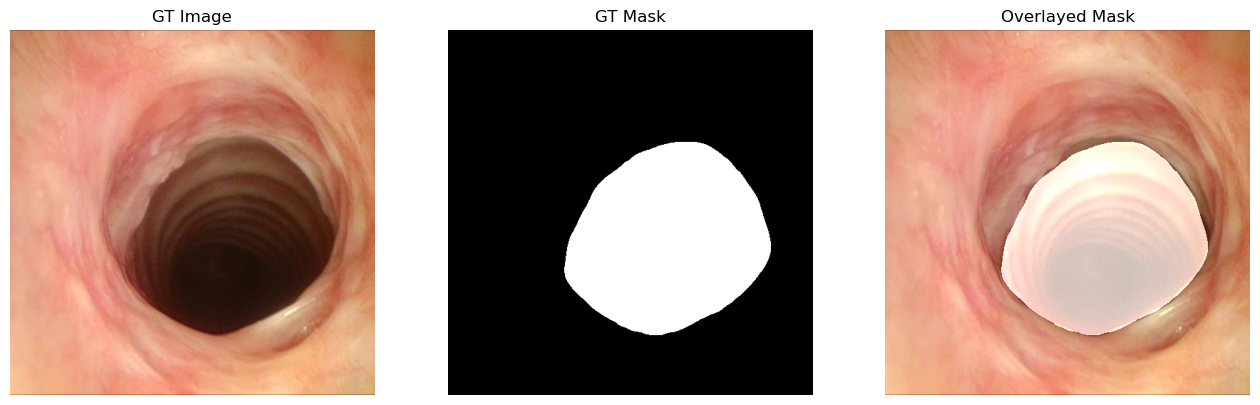

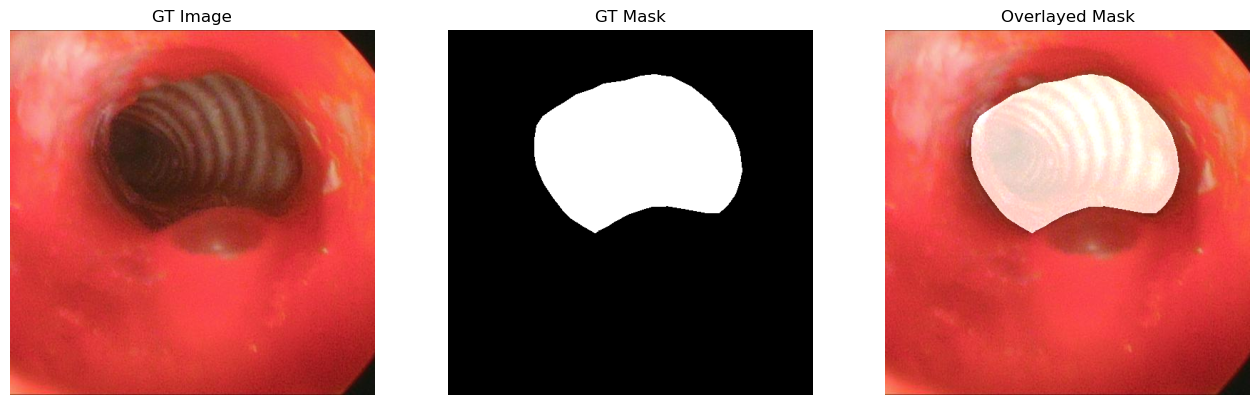

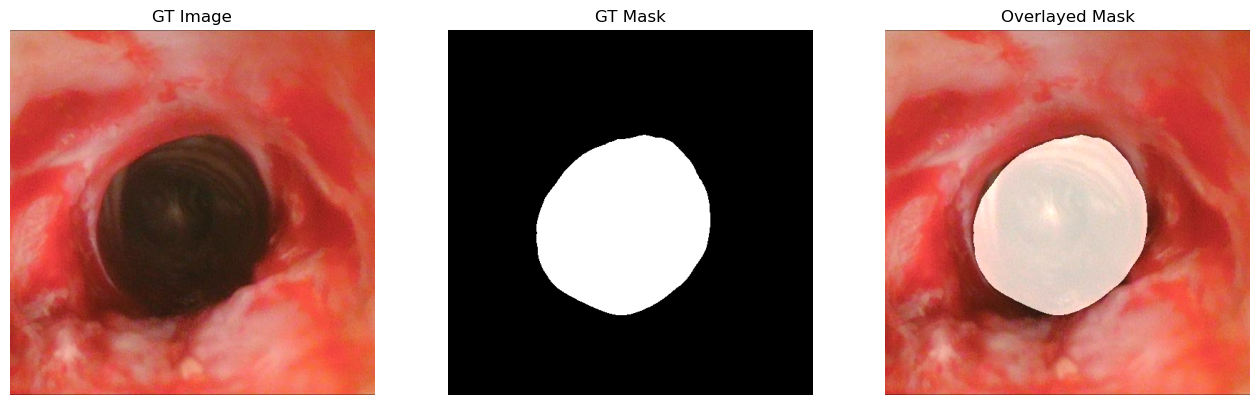

In [28]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], 
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

## Data Augmentation

We will use the following transforms as augmentations:
* RandomFlip (default mode is **"horizontal"**, with a probability of `0.5`)
* Random Brightness
* Random Contrast

In [29]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [30]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2024-02-23 12:21:36.300464: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

### Visualize Augmented Data

2024-02-23 12:21:39.524252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5418966916581696718


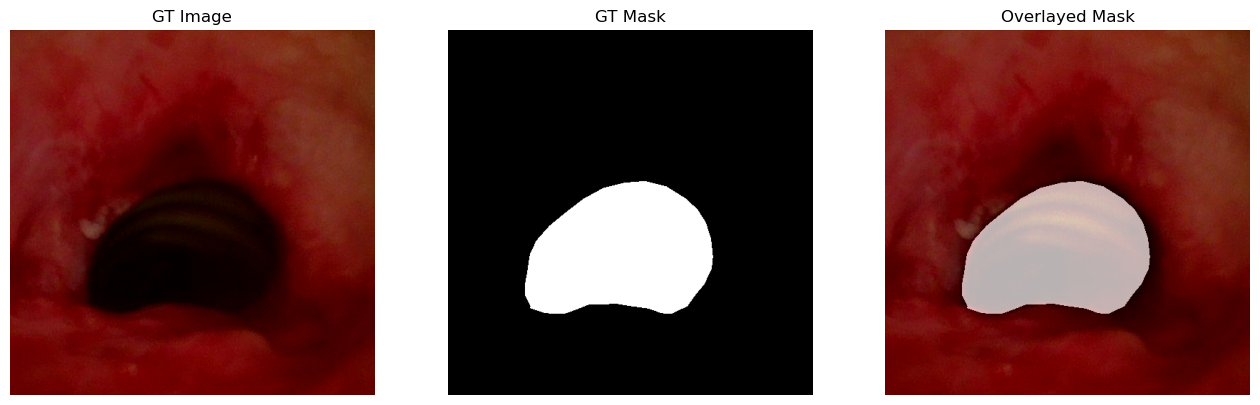

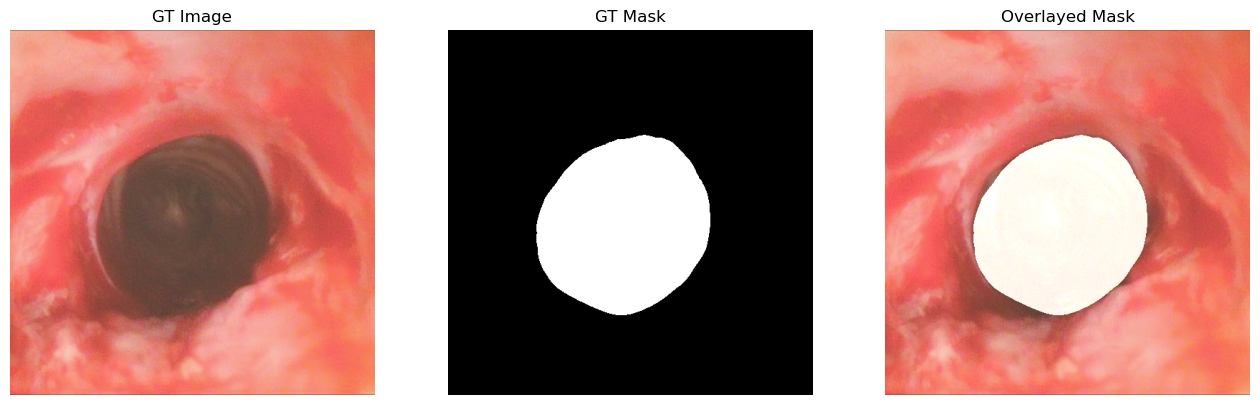

In [31]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], 
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

## Model Architecture

We will use `resnet50_v2_imagenet` feature extractor on top of the DeepLabv3 Head.

In [32]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )
print(model.summary())

Model: "deep_lab_v3_plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model (Functional)          {'P2': (None, 128, 128, 25   2355660   ['input_1[0][0]']             
                             6),                          8                                       
                              'P5': (None, 16, 16, 2048                                           
                             )}                                                                   
                                                                                                  
 spatial_pyramid_pooling (S  (None, 16, 16, 256)          1553817   ['model[0][1]']

## Evaluation Metrics

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$ 
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

In [33]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### Tensorboard and ModelCheckpoint Callbacks

In [34]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [35]:
# Build model.

# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [36]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100


2024-02-23 12:22:07.206063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-23 12:22:07.676737: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-23 12:22:08.422114: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-23 12:22:08.422150: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-02-23 12:22:08.535453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x90fc450 initialized for platform CUDA (this does not guarantee

29/29 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8538 - mean_iou: 0.6713
Epoch 1: val_mean_iou improved from -inf to 0.05766, saving model to checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.h5
29/29 [==============================] - 27s 463ms/step - loss: 0.4108 - accuracy: 0.8538 - mean_iou: 0.6713 - val_loss: 3.5891 - val_accuracy: 0.1163 - val_mean_iou: 0.0577
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9708 - mean_iou: 0.8732
Epoch 2: val_mean_iou improved from 0.05766 to 0.07811, saving model to checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.h5
29/29 [==============================] - 10s 331ms/step - loss: 0.1216 - accuracy: 0.9708 - mean_iou: 0.8732 - val_loss: 3.2873 - val_accuracy: 0.1506 - val_mean_iou: 0.0781
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9749 - mean_iou: 0.8880
Epoch 3: val_mean_iou improved from 0.07811 to 0.25841, saving model to c

## Plot hostogram of the training results

In [37]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mean_iou', 'val_loss', 'val_accuracy', 'val_mean_iou'])


In [38]:
#print(history.history)
# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

# save to csv:
hist_csv_file = 'History_lumen_ResNet50_v2_'+ dt_string +'.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [39]:
print(hist_df)

        loss  accuracy  mean_iou  val_loss  val_accuracy  val_mean_iou
0   0.410812  0.853776  0.671301  3.589131      0.116347      0.057660
1   0.121584  0.970769  0.873234  3.287298      0.150621      0.078113
2   0.084376  0.974870  0.887972  1.330865      0.445663      0.258406
3   0.070731  0.977277  0.900085  0.743642      0.713867      0.488306
4   0.059666  0.980621  0.911098  0.510470      0.808694      0.587715
..       ...       ...       ...       ...           ...           ...
95  0.008773  0.996412  0.981110  0.028035      0.990397      0.938362
96  0.008905  0.996447  0.981195  0.026897      0.990985      0.944787
97  0.008857  0.996425  0.981589  0.027859      0.990256      0.938202
98  0.008327  0.996617  0.982042  0.028066      0.990864      0.942339
99  0.008979  0.996392  0.980774  0.027867      0.990934      0.944350

[100 rows x 6 columns]


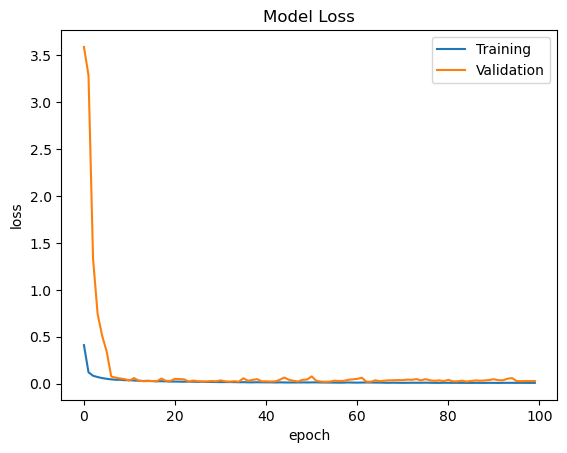

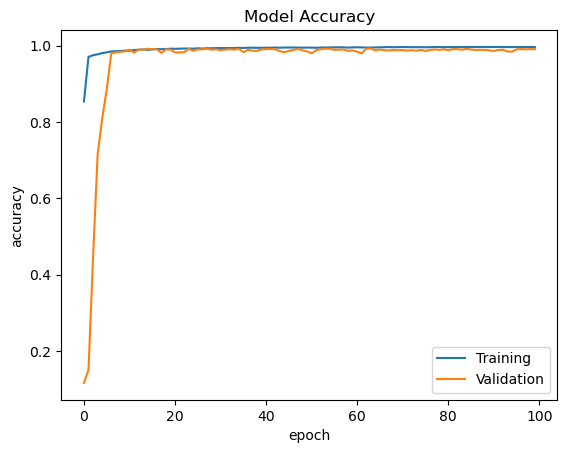

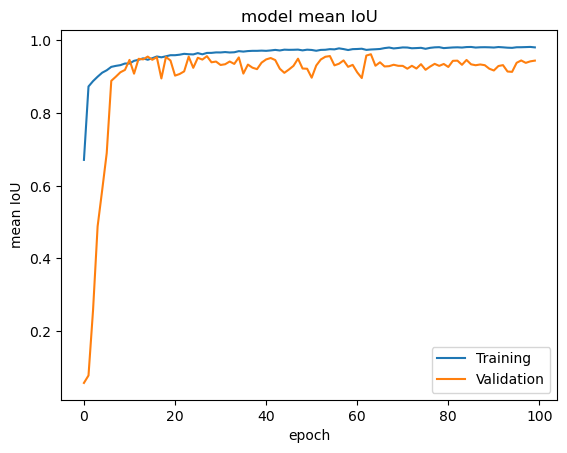

In [40]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


# summarize history for mean_iou
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model mean IoU')
plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()




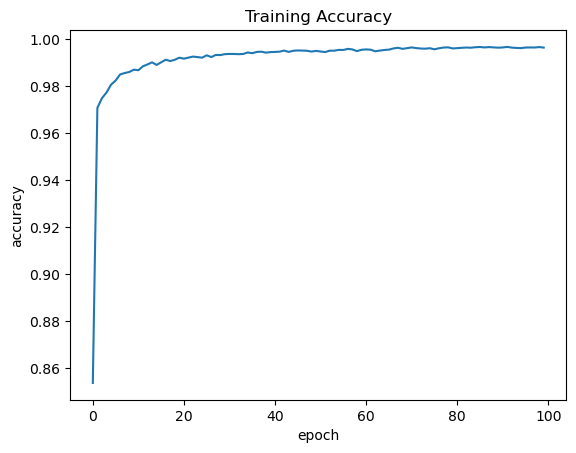

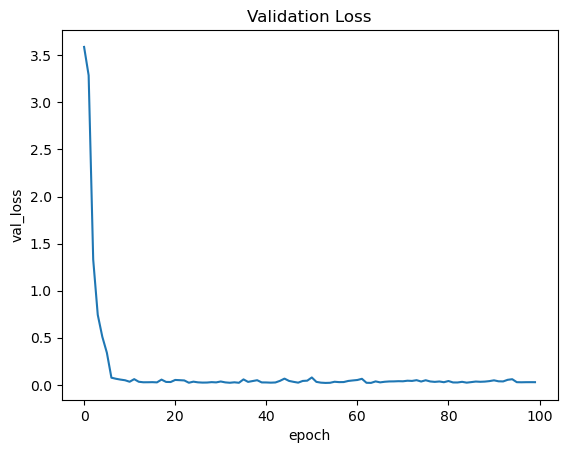

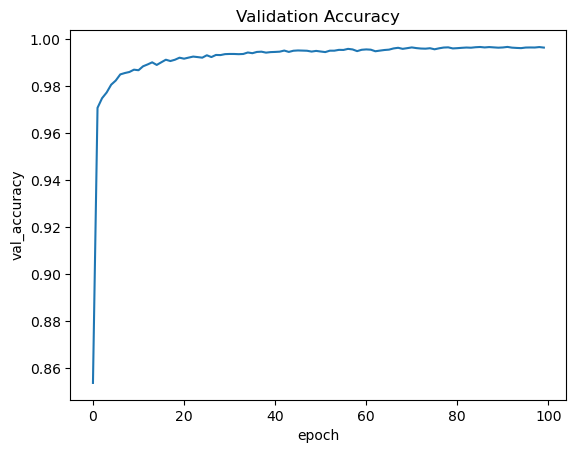

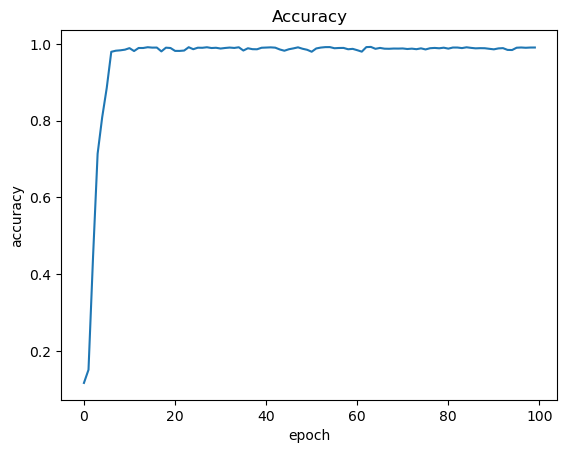

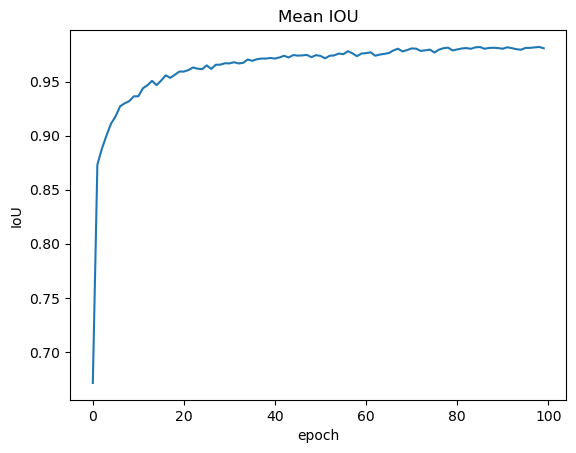

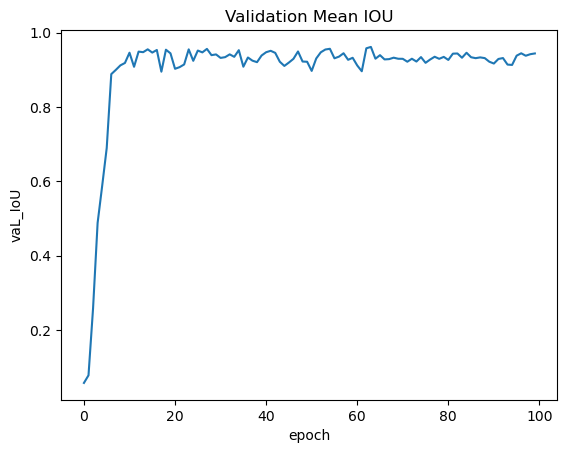

In [41]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["mean_iou"])
plt.title("Mean IOU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_mean_iou"])
plt.title("Validation Mean IOU")
plt.ylabel("vaL_IoU")
plt.xlabel("epoch")
plt.show()

#### Load Fine-tuned Model Weights

In [42]:
model.load_weights(train_config.CKPT_DIR)

#### Perform Evaluation

In [43]:
evaluate = model.evaluate(valid_dataset)

2/2 [==============================] - 0s 58ms/step - loss: 0.0204 - accuracy: 0.9925 - mean_iou: 0.9619


## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [44]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)
        
        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break
            

1/1 [==============================] - 1s 533ms/step


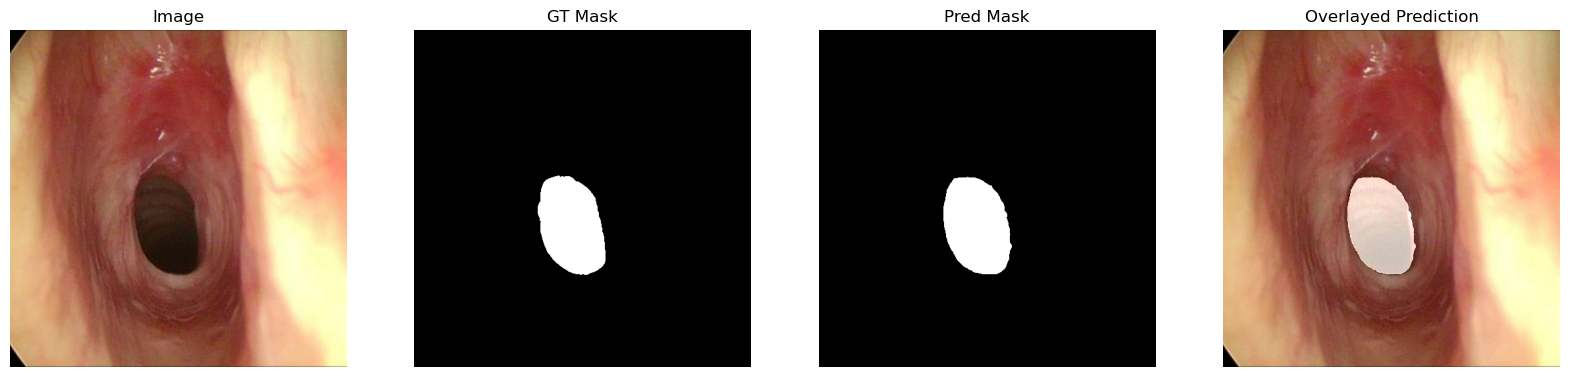

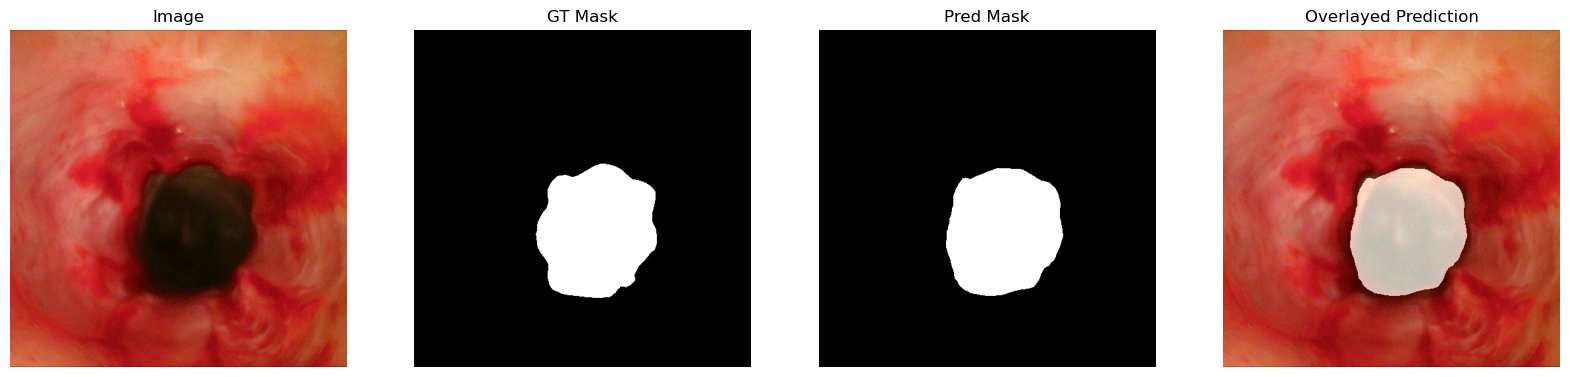

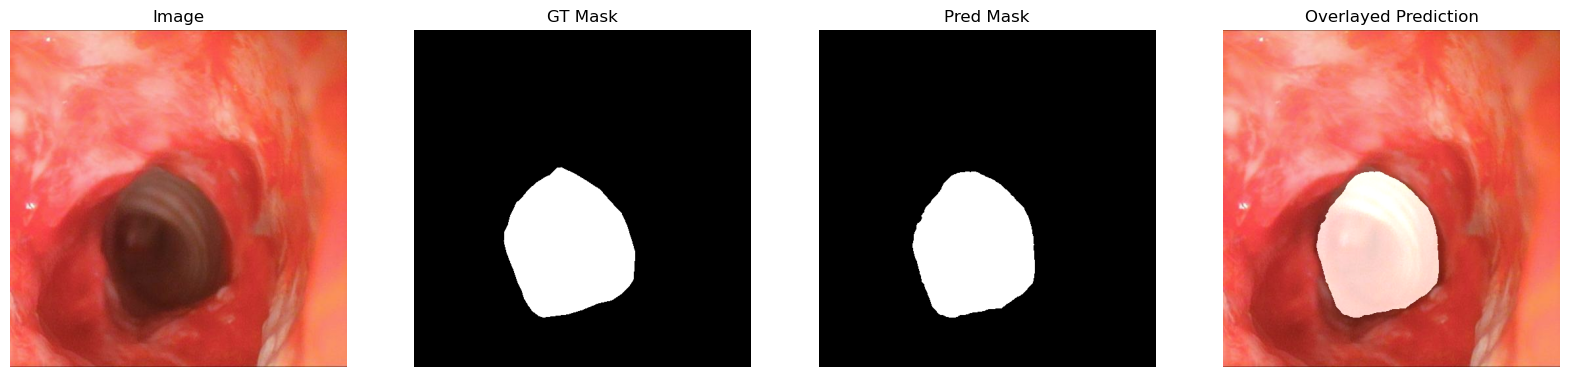

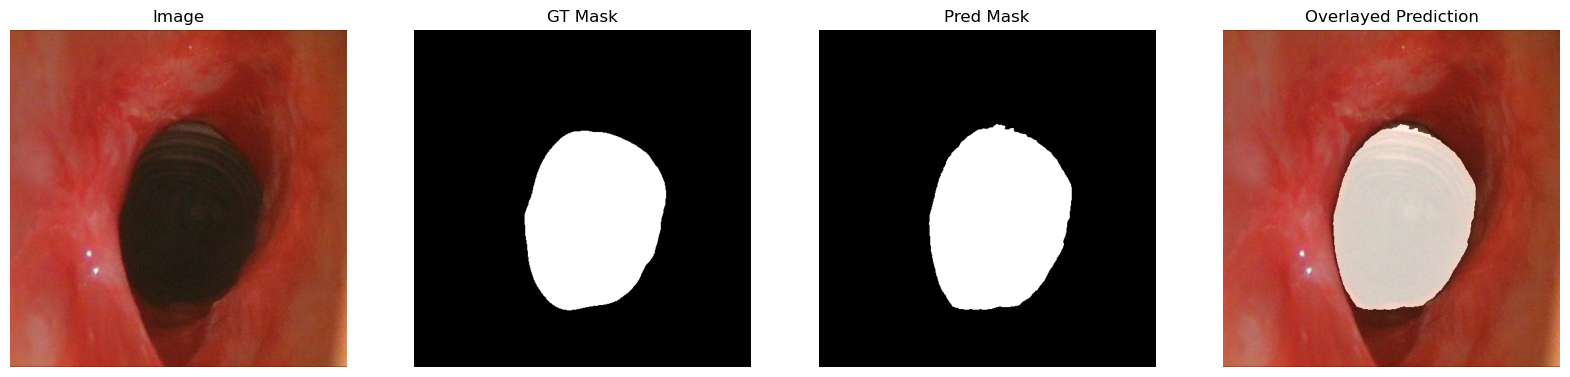

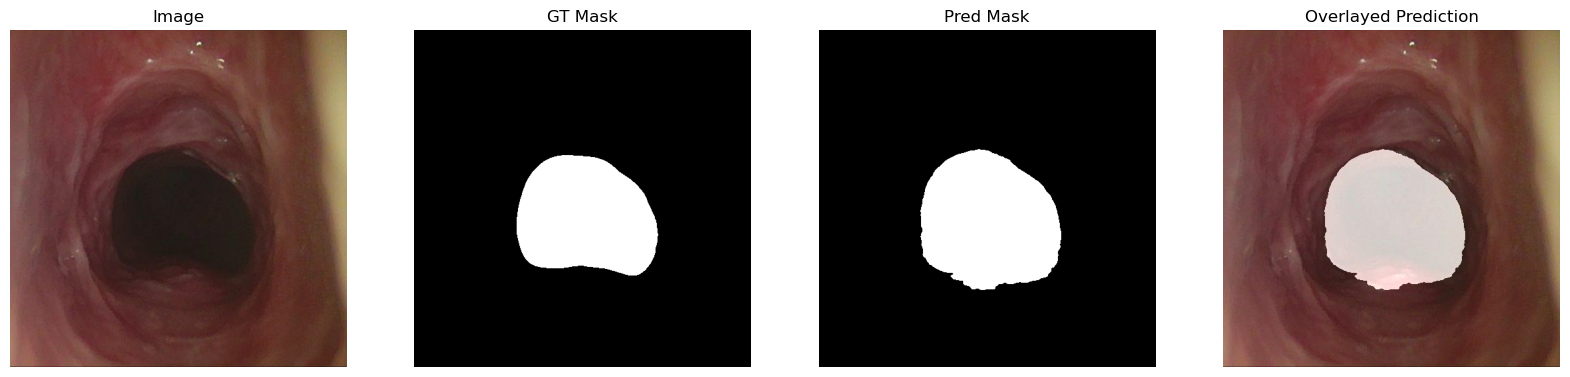

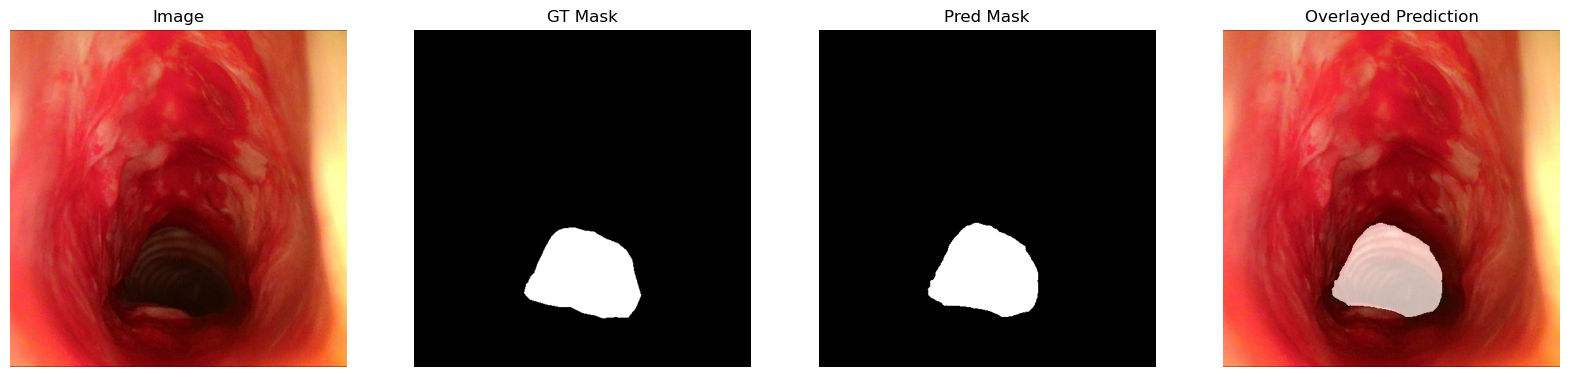

1/1 [==============================] - 0s 18ms/step


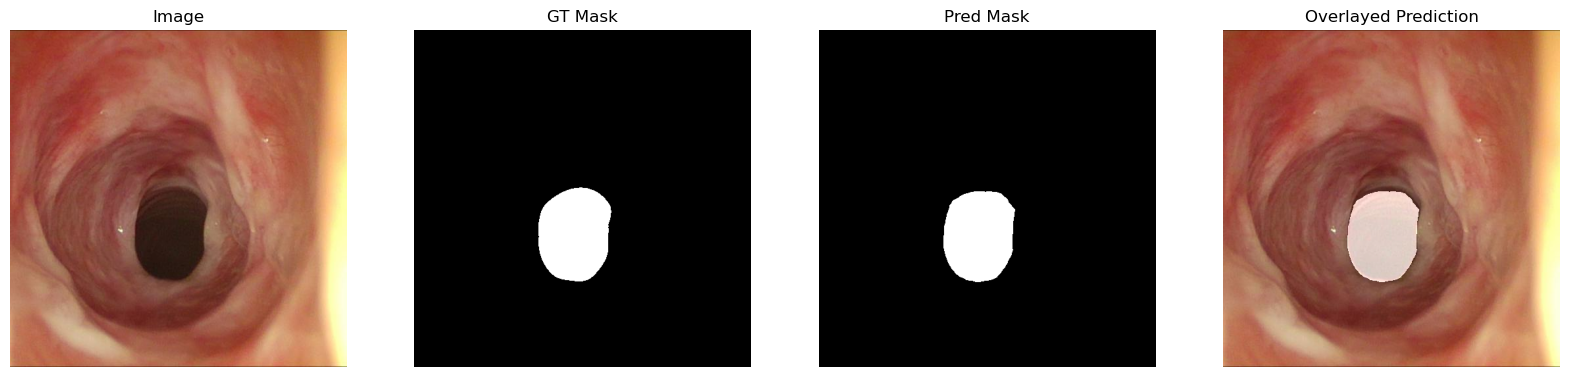

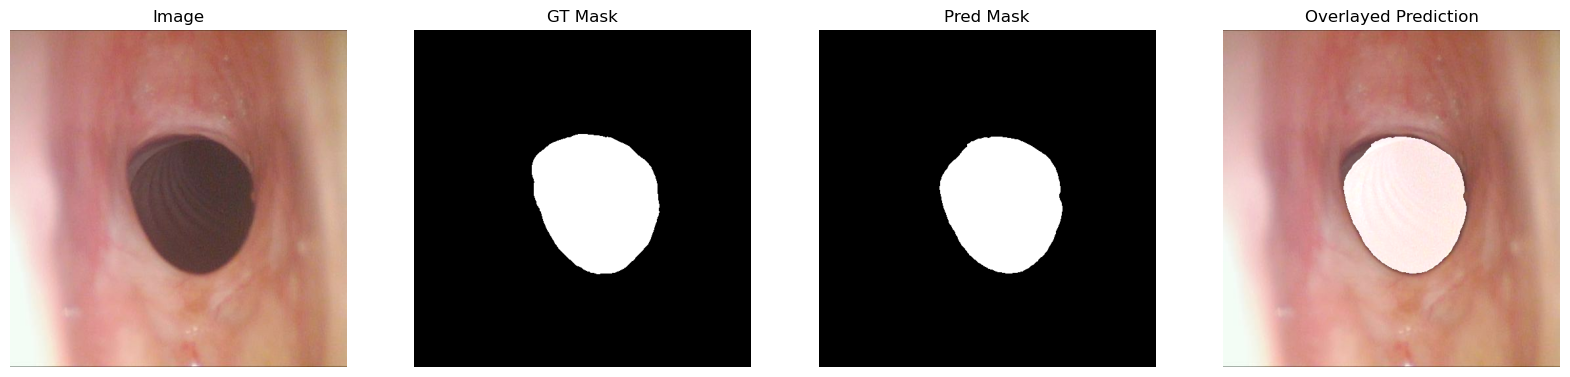

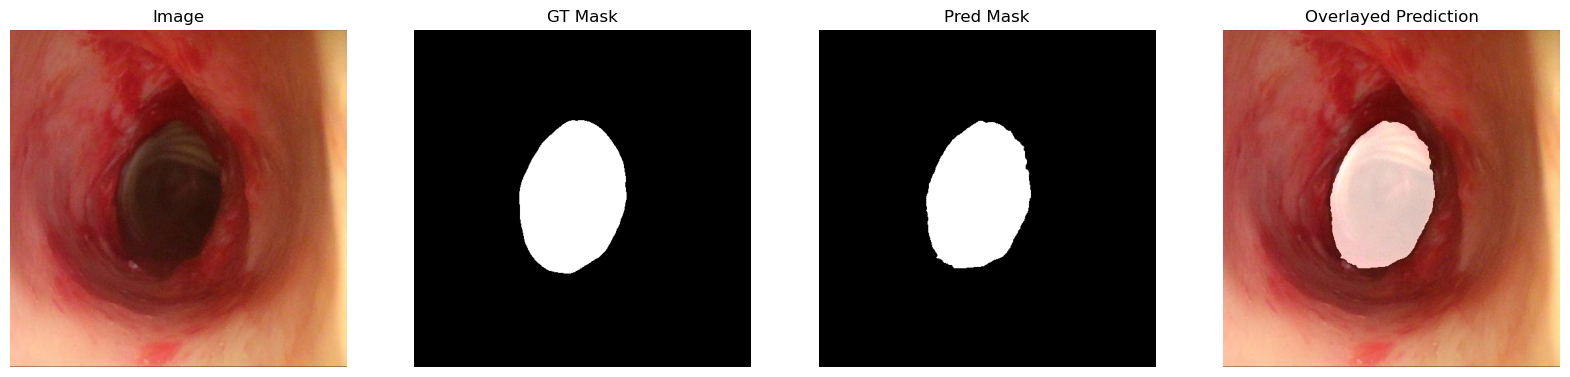

In [45]:
inference(model, valid_dataset, samples_to_plot=10)